# 2-D Double Pendulum
To simulate a double pendulum, we are going to first determine the equations of motion. We define the positions of the bobs in the pendulum using the angles the rods make with the y-axis, namely $\theta_1$ and $\theta_2$.

We take the length of the pendulums as $L_1$ and $L_2$, and masses of the bobs to be $m_1$ and $m_2$.

In [1]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m_1 m_2')
L1, L2 = smp.symbols('L_1 L_2')

In [3]:
the1, the2 = smp.symbols(r'\theta_1 \theta_2' , cls=smp.Function)

In [4]:
the1 = the1(t)
the2 = the2(t)

In [5]:
the1_d = smp.diff(the1, t)
the2_d = smp.diff(the2, t)
the1_dd = smp.diff(the1_d, t)
the2_dd = smp.diff(the2_d, t)

One can use some simple geometry to find, 
$$\begin{align*}
&x_1 = L_1 \sin \theta_1 \\
&y_1 = - L_1 \cos \theta_1 \\
&x_2 = x_1 + L_2 \sin \theta_2 \\
&y_2 = y_1 - L_2 \cos \theta_2
\end{align*}$$

Where $(x_1, y_1)$ and $(x_2, y_2)$ are the coordinates of the bobs of the pendulums in cartesian coordinate system.

In [6]:
x1 = L1 * smp.sin(the1)
y1 = - L1 * smp.cos(the1)
x2 = L2 * smp.sin(the2) + x1
y2 = - L2 * smp.cos(the2) + y1

In [7]:
x1_f = smp.lambdify((the1, the2, L1, L2), x1)
y1_f = smp.lambdify((the1, the2, L1, L2), y1)
x2_f = smp.lambdify((the1, the2, L1, L2), x2)
y2_f = smp.lambdify((the1, the2, L1, L2), y2)

Now, we compute the energies and thus obtain the lagrangian.

In [8]:
T1 = 1/2 * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
T2 = 1/2 * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
T = T1 + T2
V1 = m1*g*y1
V2 = m2*g*y2
V = V1 + V2
L = T-V

Now, we write the Euler-Lagrange equations to obtain the equations of motion

In [9]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t).simplify()

In [10]:
sols = smp.solve([LE1, LE2],(the1_dd, the2_dd), simplify=False, rational=False)

Now, we have two equations of motion of the form 
$$\frac{d^2\theta_1}{dt^2} = f(t, g, m_1, m_2, L_1, L_2, \dot{\theta_1},\dot{\theta_1}, \theta_1, \theta_2)$$
$$\frac{d^2\theta_2}{dt^2} = g(t, g, m_1, m_2, L_1, L_2, \dot{\theta_1},\dot{\theta_1}, \theta_1, \theta_2)$$

In [11]:
du1dt_f = smp.lambdify((t, g, m1, m2, L1, L2, the1_d, the2_d, the1, the2), sols[the1_dd])
du2dt_f = smp.lambdify((t, g, m1, m2, L1, L2, the1_d, the2_d, the1, the2), sols[the2_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

Now, we set the physical parameters and proceed by solving the two differential equations numerically

In [12]:
L1 = 1
L2 = 1
m1 = 1
m2 = 1
g = 9.81
Y_0 = [1,-2,1.01,-4]

Since python can't solve second order differential equations, we shall use a system of first order equations to solve for $\theta_1(t)$ and $\theta_2(t)$. We do this, by defining $u_1 = \dot{\theta_1}$ and $u_2 = \dot{\theta_2}$

In [13]:
def dSdt(S, t):
    the1, u1, the2, u2 = S
    return [
        dthe1dt_f(u1),
        du1dt_f(t, g, m1, m2, L1, L2, u1, u2, the1, the2),
        dthe2dt_f(u2),
        du2dt_f(t, g, m1, m2, L1, L2, u1, u2, the1, the2),
    ]

In [14]:
t = np.linspace(0, 50, 1000)

In [15]:
sol = odeint(dSdt, y0=Y_0, t=t)

In [16]:
theta1 = sol.T[0]
theta2 = sol.T[2]

After obtaining the solutions, we convert them into cartesian-coordinates using the functions we defined a while back

In [17]:
x1 = x1_f(theta1, theta2, L1, L2)
y1 = y1_f(theta1, theta2, L1, L2)
x2 = x2_f(theta1, theta2, L1, L2)
y2 = y2_f(theta1, theta2, L1, L2)

And now, we animate the double pendulum

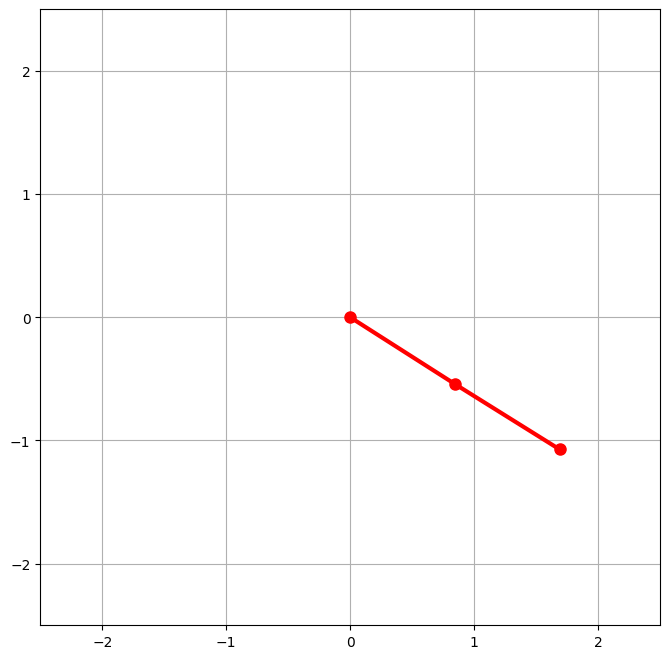

In [18]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]],[0, y1[i], y2[i]])
fig,ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([],[], 'ro-', lw=3, markersize=8)
ax.set_ylim(-2.5,2.5)
ax.set_xlim(-2.5,2.5)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('double_pendulum.gif', writer='pillow', fps=30)